In [1]:
import os
import cv2
import time
import torch
import random
import numpy as np
import albumentations as augs
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from IPython.display import clear_output

from utils import *
from models import *
from datasets import *
from evaluation import *


print('Ready')

Ready


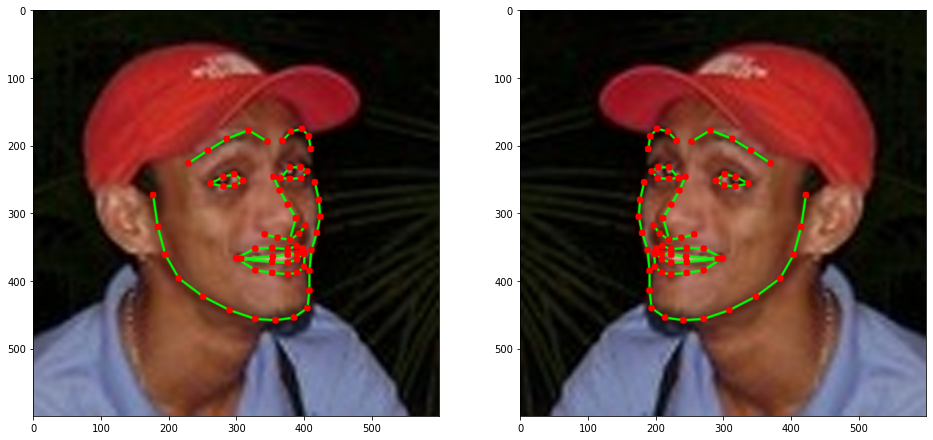

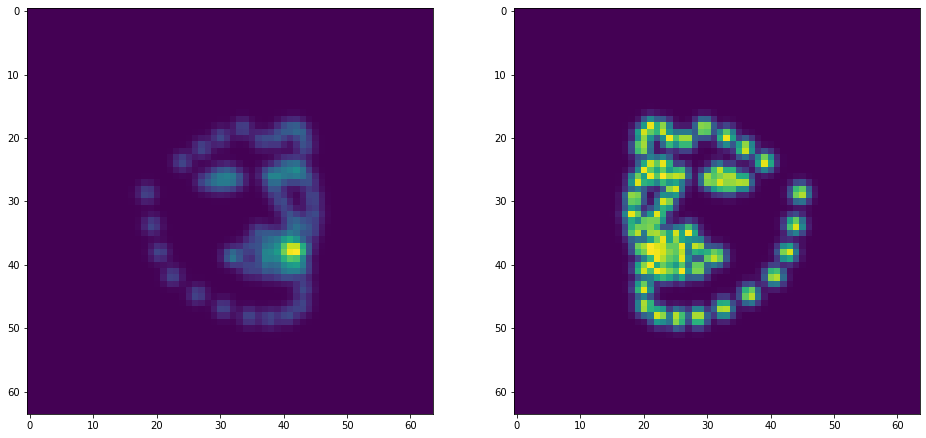

Average reconstruction error (MAE) with subpixel sampling: 2.4310343801282805e-05
Average reconstruction error (MAE) without subpixel sampling: 2.382236345468297
Average reconstruction error (MAE) of flipped heatmaps with subpixel sampling: 3.017138144572835e-05


In [4]:
# Test pts utils
im_path = './data/300w/ibug/image_050.png'
pts_path = './data/300w/ibug/image_050.pts'
im = cv2.imread(im_path)
pts = load_pts(pts_path)
flipped_pts = flip_landmarks(pts, im.shape[1])
for idx in range(pts.shape[0]):
    clear_output(wait=True)
    fig = plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    im_disp = im.copy()
    if idx > 0:
        pts_disp = pts.copy()
        pts_disp[idx:] = pts_disp[idx]
        plot_landmarks(im_disp, pts_disp, connection_thickness=2, landmark_radius=5)
    plt.imshow(im_disp[..., ::-1])
    plt.subplot(1, 2, 2)
    im_disp = im[:, ::-1, :].copy()
    if idx > 0:
        pts_disp = flipped_pts.copy()
        pts_disp[idx:] = pts_disp[idx]
        plot_landmarks(im_disp, pts_disp, connection_thickness=2, landmark_radius=5)
    plt.imshow(im_disp[..., ::-1])
    plt.show()
    time.sleep(0.1)

heatmaps = encode_landmarks(pts / im.shape[1::-1] * 64, 64, 64, 5, 1)
fig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(heatmaps.sum(axis=0))
heatmaps = encode_landmarks(flipped_pts / im.shape[1::-1] * 64, 64, 64, 5, 1, use_subpixel_sampling=True)
plt.subplot(1, 2, 2)
plt.imshow(heatmaps.max(axis=0)[0])
plt.show()
recon_err = np.abs(flipped_pts - decode_landmarks(heatmaps)[0].detach().cpu().numpy() / 64 * im.shape[1::-1]).mean()
print(f"Average reconstruction error (MAE) with subpixel sampling: {recon_err}")

heatmaps2 = encode_landmarks(flipped_pts / im.shape[1::-1] * 64, 64, 64, 3, 1, use_subpixel_sampling=False)
recon_err2 = np.abs(flipped_pts - decode_landmarks(heatmaps2)[0].detach().cpu().numpy() / 64 * im.shape[1::-1]).mean()
print(f"Average reconstruction error (MAE) without subpixel sampling: {recon_err2}")

heatmaps3 = flip_heatmaps(heatmaps)
recon_err3 = np.abs(pts - decode_landmarks(heatmaps3)[0].detach().cpu().numpy() / 64 * im.shape[1::-1]).mean()
print(f"Average reconstruction error (MAE) of flipped heatmaps with subpixel sampling: {recon_err3}")

180689 samples located.
Samples augmented using the improved preprocessing pipeline:


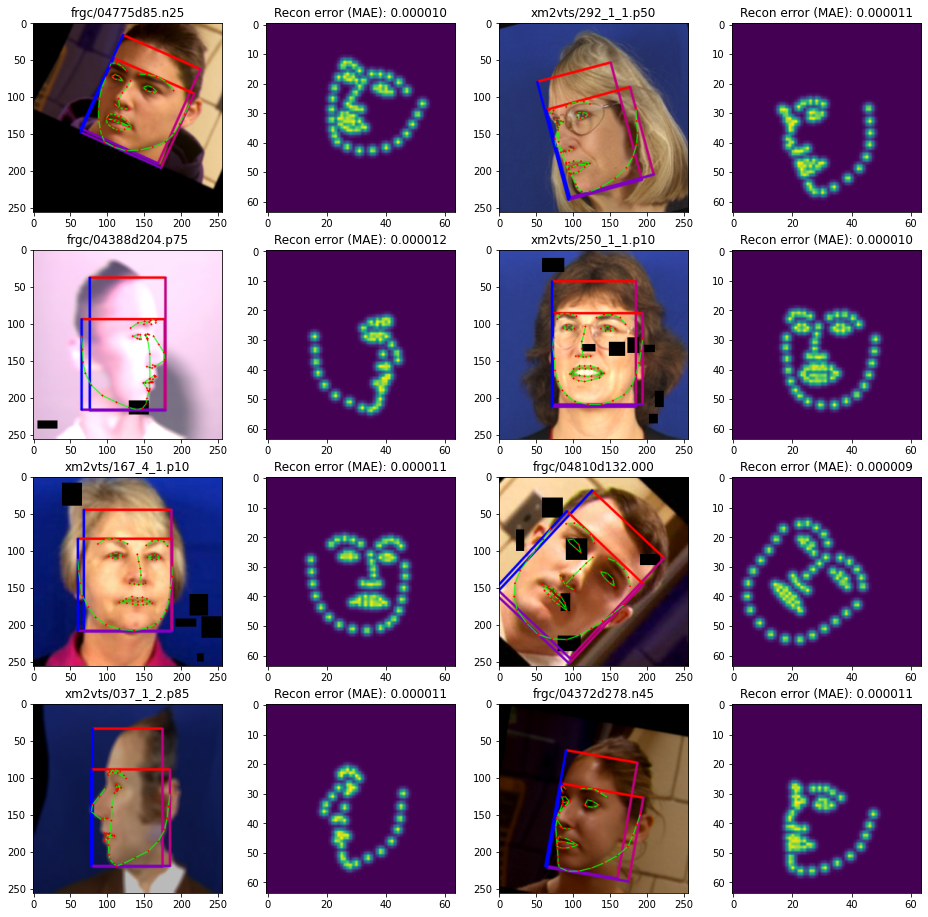

Samples augmented using the original preprocessing pipeline:


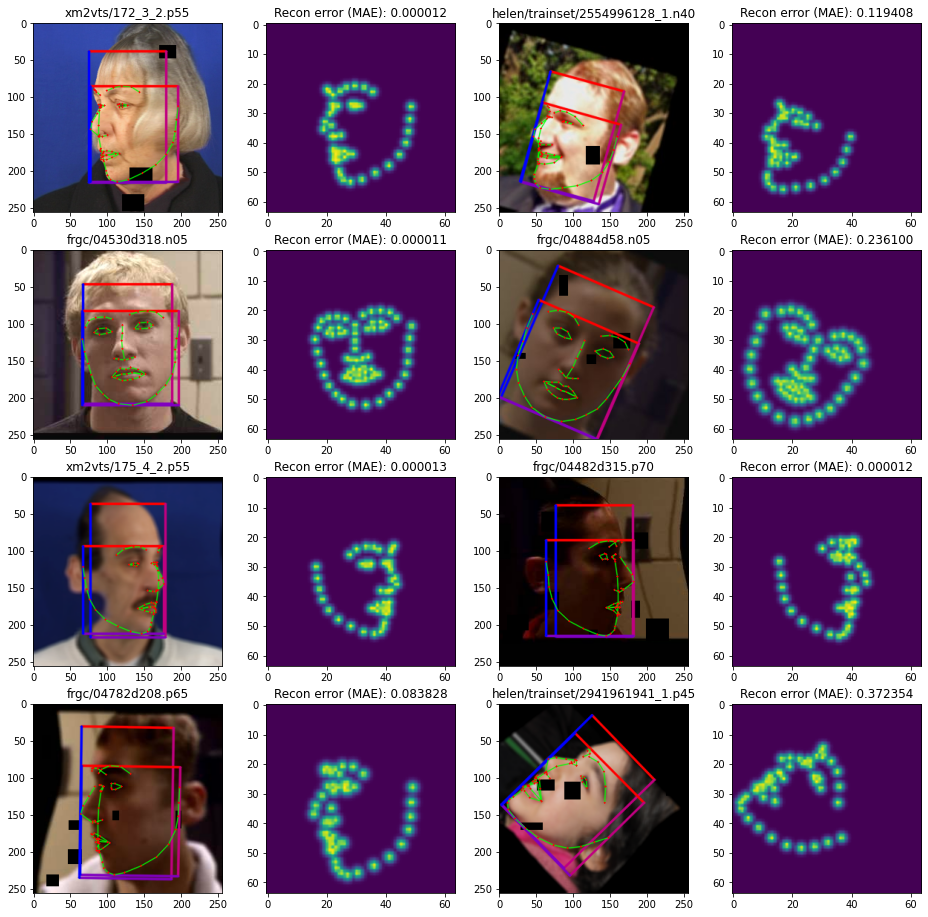

In [11]:
# Test the dataset class
ibug_300w_lp_train = LandmarkDataset('data/300w_lp.tsv', LandmarkDataset.get_partitions('300w_lp', 'train'),
                                     random_flip=True)
ibug_300w_lp_train.geometric_transform = augs.ShiftScaleRotate(scale_limit=0.2, rotate_limit=50, p=0.5,
                                                               border_mode=cv2.BORDER_CONSTANT)
ibug_300w_lp_train.content_transform = augs.Compose([augs.Blur(p=0.5),
                                                     augs.ColorJitter(0.3, 0.3, 0.3, 0,3, p=1.0),
                                                     augs.ImageCompression(quality_lower=30, p=0.5),
                                                     augs.CoarseDropout(min_holes=1, max_holes=8,
                                                                        min_width=0.03125, min_height=0.03125,
                                                                        max_width=0.125, max_height=0.125, p=0.5)])
print(f"{len(ibug_300w_lp_train)} samples located.")

# Show some examples from the dataset
for ibug_300w_lp_train.config.use_improved_preprocessing in [True, False]:
    if ibug_300w_lp_train.config.use_improved_preprocessing:
        print('Samples augmented using the improved preprocessing pipeline:')
    else:
        print('Samples augmented using the original preprocessing pipeline:')
    fig = plt.figure(figsize=(16, 16))
    for idx in range(8):
        plt.subplot(4, 4, idx * 2 + 1)
        im, htm, pts, fcs, lbcs, metadata = ibug_300w_lp_train[random.randint(0, len(ibug_300w_lp_train) - 1)]
        pts, fcs, lbcs = pts.detach().cpu().numpy(), fcs.detach().cpu().numpy(), lbcs.detach().cpu().numpy()
        im = (im.numpy().transpose((1, 2, 0)) * 255.0).astype(np.uint8)
        cv2.line(im, tuple(fcs[0].astype(int).tolist()), tuple(fcs[1].astype(int).tolist()),
                 color=(255, 0, 0), thickness=2, lineType=cv2.LINE_AA)
        cv2.line(im, tuple(fcs[1].astype(int).tolist()), tuple(fcs[2].astype(int).tolist()),
                 color=(192, 0, 128), thickness=2, lineType=cv2.LINE_AA)
        cv2.line(im, tuple(fcs[2].astype(int).tolist()), tuple(fcs[3].astype(int).tolist()),
                 color=(128, 0, 192), thickness=2, lineType=cv2.LINE_AA)
        cv2.line(im, tuple(fcs[3].astype(int).tolist()), tuple(fcs[0].astype(int).tolist()),
                 color=(0, 0, 255), thickness=2, lineType=cv2.LINE_AA)
        cv2.line(im, tuple(lbcs[0].astype(int).tolist()), tuple(lbcs[1].astype(int).tolist()),
                 color=(255, 0, 0), thickness=2, lineType=cv2.LINE_AA)
        cv2.line(im, tuple(lbcs[1].astype(int).tolist()), tuple(lbcs[2].astype(int).tolist()),
                 color=(192, 0, 128), thickness=2, lineType=cv2.LINE_AA)
        cv2.line(im, tuple(lbcs[2].astype(int).tolist()), tuple(lbcs[3].astype(int).tolist()),
                 color=(128, 0, 192), thickness=2, lineType=cv2.LINE_AA)
        cv2.line(im, tuple(lbcs[3].astype(int).tolist()), tuple(lbcs[0].astype(int).tolist()),
                 color=(0, 0, 255), thickness=2, lineType=cv2.LINE_AA)
        plot_landmarks(im, pts, landmark_colour=(255, 0, 0))
        plt.imshow(im)
        plt.title(os.path.join(metadata['subset'], metadata['split'],
                               os.path.splitext(os.path.basename(metadata['im_path']))[0]))
        plt.subplot(4, 4, idx * 2 + 2)
        plt.imshow(htm.max(axis=0)[0])
        recon_err = np.abs(pts - decode_landmarks(htm)[0].detach().cpu().numpy() / 64 * im.shape[1::-1]).mean()
        plt.title(f"Recon error (MAE): {recon_err:.06f}")
    plt.show()

Data loader created.
Pretrained model loaded.


Test batch:   0%|          | 0/576 [00:00<?, ?it/s]

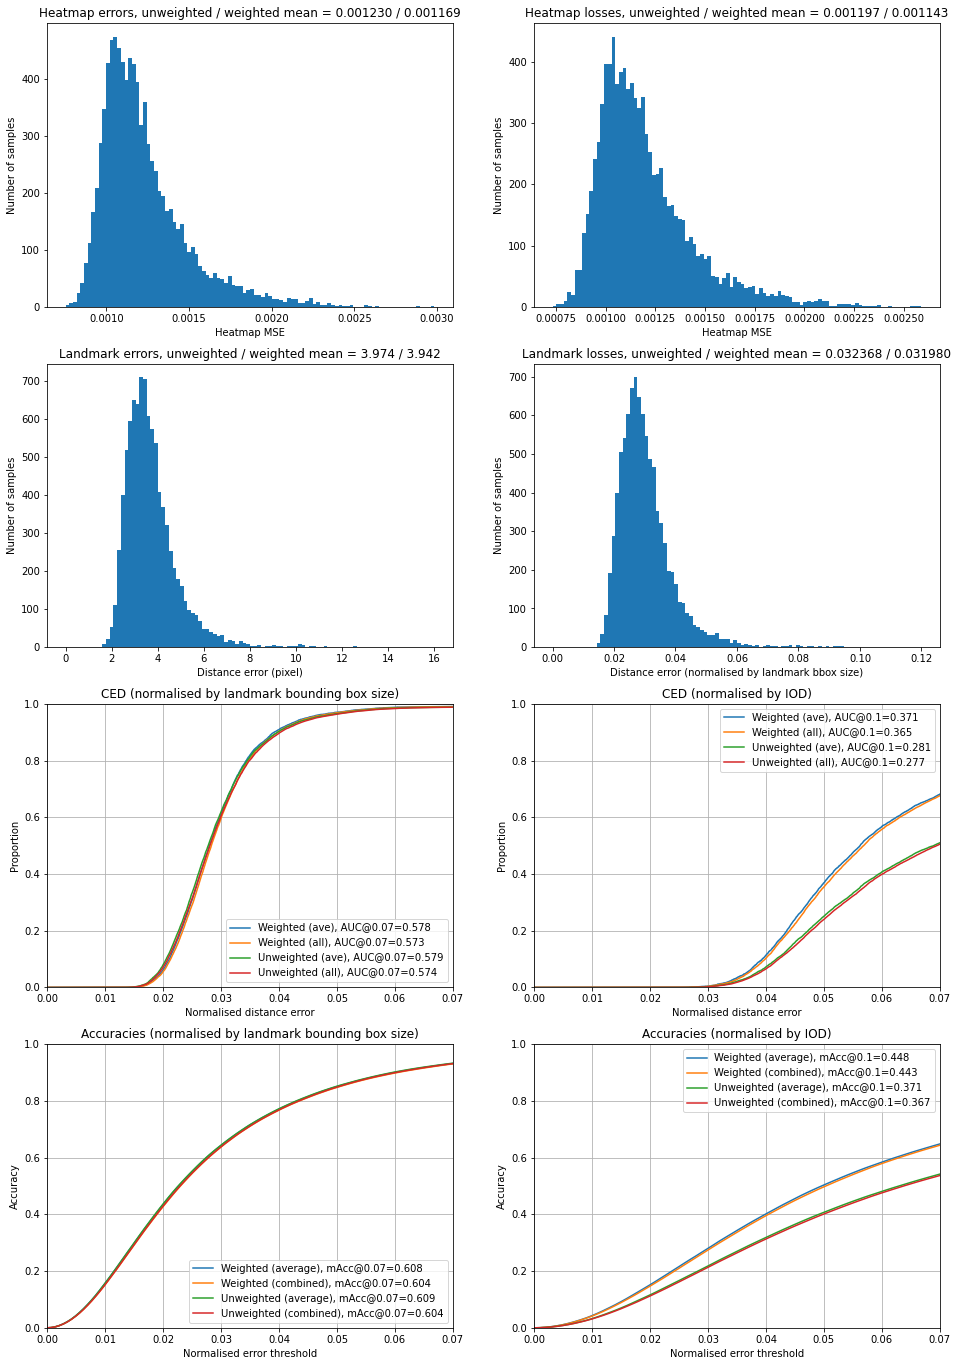

In [2]:
# Test the evaluation function
ibug_300w_lp_test = LandmarkDataset('./data/300w_lp.tsv', LandmarkDataset.get_partitions('300w_lp', 'test'))
test_loader = DataLoader(ibug_300w_lp_test, batch_size=16, shuffle=False, num_workers=32, pin_memory=True)
print('Data loader created.')

fan = FAN(FAN.create_config(num_modules=4, use_avg_pool=True)).to('cuda:0')
fan.load_state_dict(torch.load('./pretrained/2dfan4.pth', map_location='cuda:0'))
fan.eval()
print('Pretrained model loaded.')

torch.cuda.empty_cache()
with tqdm(total=len(test_loader), desc='Test batch') as pbar:
    results = run_model(fan, test_loader, pbar=pbar)
del fan
torch.cuda.empty_cache()

# Get IODs and landmark bbox sizes
iods = get_iods(results['landmarks'])
lmk_bbox_sizes = get_bbox_sizes(results['landmark_bbox_corners'])[0]

# Compute landmark errors
all_lmk_errors = compute_landmark_errors(results['predicted_landmarks'], results['landmarks'])
ave_lmk_errors = compute_landmark_errors(results['predicted_landmarks'].mean(axis=1), results['landmarks'])

# Compute AUCs
th_lbs = 0.07
auc1, errs1, ticks1 = compute_auc(ave_lmk_errors, th_lbs, lmk_bbox_sizes, results['sample_weights'])
auc2, errs2, ticks2 = compute_auc(all_lmk_errors, th_lbs, lmk_bbox_sizes, results['sample_weights'])
auc3, errs3, ticks3 = compute_auc(ave_lmk_errors, th_lbs, lmk_bbox_sizes)
auc4, errs4, ticks4 = compute_auc(all_lmk_errors, th_lbs, lmk_bbox_sizes)


th_iod = 0.1
auc5, errs5, ticks5 = compute_auc(ave_lmk_errors, th_iod, iods, results['sample_weights'])
auc6, errs6, ticks6 = compute_auc(all_lmk_errors, th_iod, iods, results['sample_weights'])
auc7, errs7, ticks7 = compute_auc(ave_lmk_errors, th_iod, iods)
auc8, errs8, ticks8 = compute_auc(all_lmk_errors, th_iod, iods)

# Compute accuracies
acc1 = [compute_accuracy(ave_lmk_errors, th, lmk_bbox_sizes, results['sample_weights'])
        for th in np.arange(0, th_lbs * 1.001, th_lbs / 100)]
acc2 = [compute_accuracy(all_lmk_errors, th, lmk_bbox_sizes, results['sample_weights'])
        for th in np.arange(0, th_lbs * 1.001, th_lbs / 100)]
acc3 = [compute_accuracy(ave_lmk_errors, th, lmk_bbox_sizes)
        for th in np.arange(0, th_lbs * 1.001, th_lbs / 100)]
acc4 = [compute_accuracy(all_lmk_errors, th, lmk_bbox_sizes)
        for th in np.arange(0, th_lbs * 1.001, th_lbs / 100)]

acc5 = [compute_accuracy(ave_lmk_errors, th, iods, results['sample_weights'])
        for th in np.arange(0, th_iod * 1.001, th_iod / 100)]
acc6 = [compute_accuracy(all_lmk_errors, th, iods, results['sample_weights'])
        for th in np.arange(0, th_iod * 1.001, th_iod / 100)]
acc7 = [compute_accuracy(ave_lmk_errors, th, iods)
        for th in np.arange(0, th_iod * 1.001, th_iod / 100)]
acc8 = [compute_accuracy(all_lmk_errors, th, iods)
        for th in np.arange(0, th_iod * 1.001, th_iod / 100)]

# Plot histograms of heatmap mse losses and heatmap errors
fig = plt.figure(figsize=(16, 24))
plt.subplot(4, 2, 1)
_ = plt.hist(results['heatmap_errors'].mean(axis=(-1, -2)), bins=100)
unweighted_mean = results['heatmap_errors'].mean()
weighted_mean = (results['heatmap_errors'].mean(axis=(-1, -2)) *
                 results['sample_weights']).mean() / results['sample_weights'].mean()
plt.title(f"Heatmap errors, unweighted / weighted mean = " +
          f"{unweighted_mean:.6f} / {weighted_mean:.6f}")
plt.xlabel('Heatmap MSE')
plt.ylabel('Number of samples')
plt.subplot(4, 2, 2)
_ = plt.hist(results['heatmap_mse_losses'].mean(axis=-1), bins=100)
unweighted_mean = results['heatmap_mse_losses'].mean()
weighted_mean = (results['heatmap_mse_losses'].mean(axis=-1) *
                 results['sample_weights']).mean() / results['sample_weights'].mean()
plt.title(f"Heatmap losses, unweighted / weighted mean = " +
          f"{unweighted_mean:.6f} / {weighted_mean:.6f}")
plt.xlabel('Heatmap MSE')
plt.ylabel('Number of samples')

# Plot histograms of landmark distance losses and landmark errors
plt.subplot(4, 2, 3)
mean_lmk_errors = all_lmk_errors.mean(axis=1)
_ = plt.hist(mean_lmk_errors.mean(axis=-1), bins=100, range=(0, 16))
unweighted_mean = mean_lmk_errors.mean()
weighted_mean = (mean_lmk_errors.mean(axis=-1) *
                 results['sample_weights']).mean() / results['sample_weights'].mean()
plt.title(f"Landmark errors, unweighted / weighted mean = " +
          f"{unweighted_mean:.3f} / {weighted_mean:.3f}")
plt.xlabel('Distance error (pixel)')
plt.ylabel('Number of samples')
plt.subplot(4, 2, 4)
normalised_lmk_loss = (results['landmark_distance_losses'].mean(axis=-1) /
                       np.clip(lmk_bbox_sizes, np.finfo(lmk_bbox_sizes.dtype).eps, None))
_ = plt.hist(normalised_lmk_loss, bins=100, range=(0, 0.12))
unweighted_mean = normalised_lmk_loss.mean()
weighted_mean = (normalised_lmk_loss *
                 results['sample_weights']).mean() / results['sample_weights'].mean()
plt.title(f"Landmark losses, unweighted / weighted mean = " +
          f"{unweighted_mean:.6f} / {weighted_mean:.6f}")
plt.xlabel('Distance error (normalised by landmark bbox size)')
plt.ylabel('Number of samples')

# Plot CED curves
plt.subplot(4, 2, 5)
plt.plot(errs1, ticks1, label=f"Weighted (ave), AUC@{th_lbs}={auc1:.03f}")
plt.plot(errs2, ticks2, label=f"Weighted (all), AUC@{th_lbs}={auc2:.03f}")
plt.plot(errs3, ticks3, label=f"Unweighted (ave), AUC@{th_lbs}={auc3:.03f}")
plt.plot(errs4, ticks4, label=f"Unweighted (all), AUC@{th_lbs}={auc4:.03f}")
plt.title('CED (normalised by landmark bounding box size)')
plt.xlim(0, th_lbs)
plt.ylim(0, 1)
plt.xlabel('Normalised distance error')
plt.ylabel('Proportion')
plt.legend()
plt.grid('both')
plt.subplot(4, 2, 6)
plt.plot(errs5, ticks5, label=f"Weighted (ave), AUC@{th_iod}={auc5:.03f}")
plt.plot(errs6, ticks6, label=f"Weighted (all), AUC@{th_iod}={auc6:.03f}")
plt.plot(errs7, ticks7, label=f"Unweighted (ave), AUC@{th_iod}={auc7:.03f}")
plt.plot(errs8, ticks8, label=f"Unweighted (all), AUC@{th_iod}={auc8:.03f}")
plt.title('CED (normalised by IOD)')
plt.xlim(0, th_lbs)
plt.ylim(0, 1)
plt.xlabel('Normalised distance error')
plt.ylabel('Proportion')
plt.legend()
plt.grid('both')

# Plot accuracy curves
plt.subplot(4, 2, 7)
plt.plot(np.arange(0, th_lbs * 1.001, th_lbs / 100), acc1,
         label=f"Weighted (average), mAcc@{th_lbs}={np.mean(acc1[1:]):.3f}")
plt.plot(np.arange(0, th_lbs * 1.001, th_lbs / 100), acc2,
         label=f"Weighted (combined), mAcc@{th_lbs}={np.mean(acc2[1:]):.3f}")
plt.plot(np.arange(0, th_lbs * 1.001, th_lbs / 100), acc3,
         label=f"Unweighted (average), mAcc@{th_lbs}={np.mean(acc3[1:]):.3f}")
plt.plot(np.arange(0, th_lbs * 1.001, th_lbs / 100), acc4,
         label=f"Unweighted (combined), mAcc@{th_lbs}={np.mean(acc4[1:]):.3f}")
plt.title('Accuracies (normalised by landmark bounding box size)')
plt.xlim(0, th_lbs)
plt.ylim(0, 1)
plt.xlabel('Normalised error threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.grid('both')
plt.subplot(4, 2, 8)
plt.plot(np.arange(0, th_iod * 1.001, th_iod / 100), acc5,
         label=f"Weighted (average), mAcc@{th_iod}={np.mean(acc5[1:]):.3f}")
plt.plot(np.arange(0, th_iod * 1.001, th_iod / 100), acc6,
         label=f"Weighted (combined), mAcc@{th_iod}={np.mean(acc6[1:]):.3f}")
plt.plot(np.arange(0, th_iod * 1.001, th_iod / 100), acc7,
         label=f"Unweighted (average), mAcc@{th_iod}={np.mean(acc7[1:]):.3f}")
plt.plot(np.arange(0, th_iod * 1.001, th_iod / 100), acc8,
         label=f"Unweighted (combined), mAcc@{th_iod}={np.mean(acc8[1:]):.3f}")
plt.title('Accuracies (normalised by IOD)')
plt.xlim(0, th_lbs)
plt.ylim(0, 1)
plt.xlabel('Normalised error threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.grid('both')